# Credit Card Fraud Detection con GANs y Modelos Tradicionales

Este notebook aborda el problema de detección de fraude en tarjetas de crédito usando técnicas avanzadas de oversampling con GANs y modelos de clasificación tradicionales.

## Objetivos
- Analizar el desbalance del dataset.
- Preprocesar los datos (escalado, limpieza).
- Generar fraudes sintéticos con GANs (CTGAN).
- Entrenar y evaluar modelos tradicionales (RandomForest, XGBoost, etc.).
- Medir desempeño con métricas adecuadas para desbalance.

---

## Imports y configuración inicial

In [9]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Importar CTGAN
from ctgan import CTGAN
# Configuración de visualización

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

## Cargar y explorar el dataset

In [10]:
# Cargar el dataset
df = pd.read_csv('creditcard.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


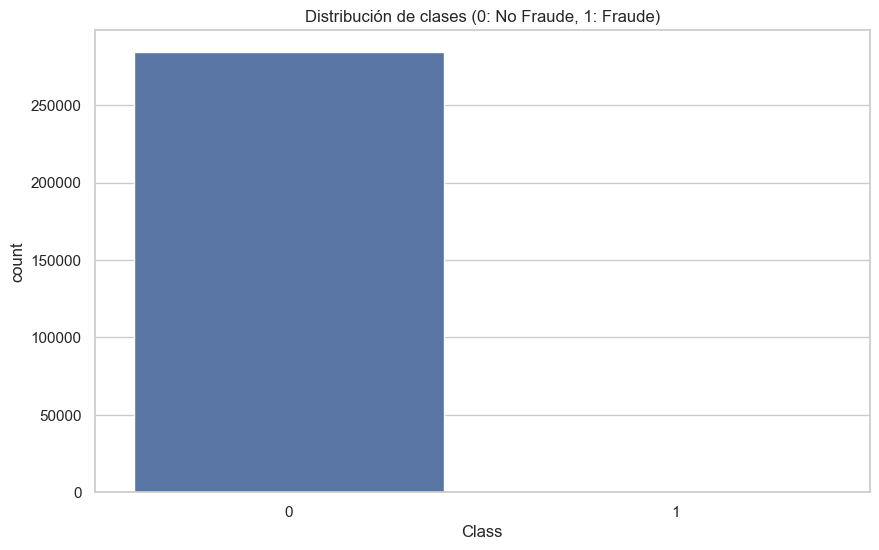

In [11]:
# Revisar balance de clases
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title('Distribución de clases (0: No Fraude, 1: Fraude)')
plt.show()

## Observaciones iniciales

- El dataset está altamente desbalanceado (~0.17% fraudes).
- Las variables V1-V28 ya están transformadas (PCA).
- 'Amount' y 'Time' requieren escalado.

## Preprocesamiento de datos

In [12]:
# Escalar 'Amount' y 'Time'
scaler = MinMaxScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

# Separar features y target
X = df.drop('Class', axis=1)
y = df['Class']

In [13]:
# Separar en train y test (mantener test sin tocar para evaluación realista)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (227845, 30), Test shape: (56962, 30)


## Oversampling con CTGAN (Generar fraudes sintéticos)

In [14]:
# Filtrar solo fraudes para entrenar la GAN
fraud_train = X_train[y_train == 1].copy()
fraud_train['Class'] = 1

# Entrenar CTGAN solo con fraudes
ctgan = CTGAN(epochs=300, verbose=True)
ctgan.fit(fraud_train)

# Generar fraudes sintéticos para aumentar la proporción a 5% en el set de entrenamiento
n_frauds_needed = int(0.05 * len(X_train)) - sum(y_train == 1)
synthetic_frauds = ctgan.sample(n_frauds_needed)

# Combinar con el set de entrenamiento real
X_train_syn = pd.concat([X_train, synthetic_frauds.drop('Class', axis=1)])
y_train_syn = pd.concat([y_train, synthetic_frauds['Class']])

print(f"Nuevos fraudes sintéticos: {len(synthetic_frauds)}")
print(f"Total fraudes en entrenamiento: {sum(y_train_syn == 1)}")

Gen. (-3.39) | Discrim. (0.06): 100%|██████████| 300/300 [00:12<00:00, 23.26it/s] 



Nuevos fraudes sintéticos: 10998
Total fraudes en entrenamiento: 11392


## Entrenamiento de modelo tradicional (RandomForest)

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_syn, y_train_syn)

# Predicción en test
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

## Evaluación del modelo

              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8966    0.7959    0.8432        98

    accuracy                         0.9995     56962
   macro avg     0.9481    0.8979    0.9215     56962
weighted avg     0.9995    0.9995    0.9995     56962



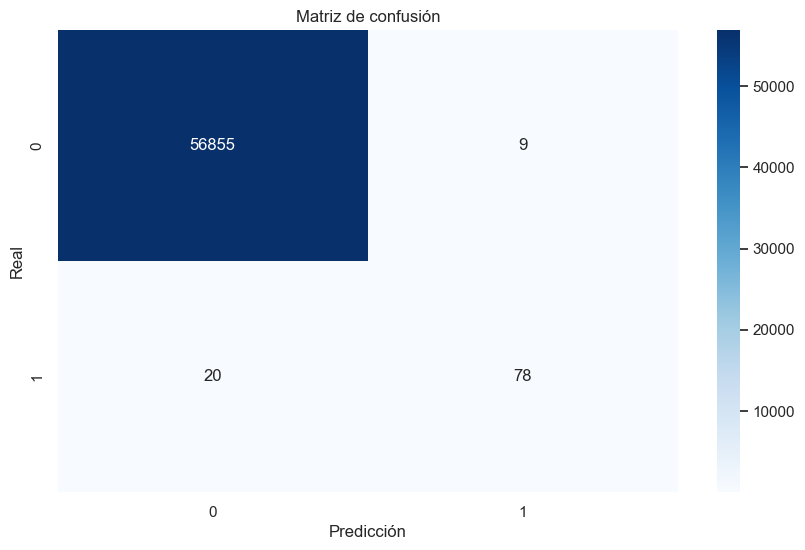

PR-AUC: 0.8656


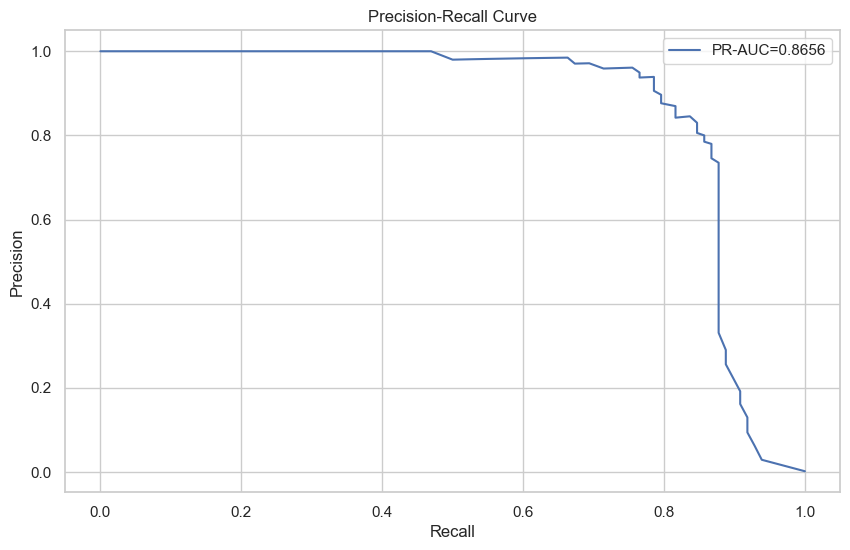

In [ ]:
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f'PR-AUC: {pr_auc:.4f}')
plt.plot(recall, precision, label=f'PR-AUC={pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Clase 0 (No Fraude):

- Precision: 0.9996 — De todas las transacciones predichas como no fraude, el 99.96% realmente no eran fraude.
- Recall: 0.9998 — De todas las transacciones realmente no fraudulentas, el 99.98% fueron correctamente identificadas.
- F1-score: 0.9997 — Excelente equilibrio entre precisión y recall.

Clase 1 (Fraude):

- Precision: 0.8966 — De todas las transacciones predichas como fraude, el 89.66% realmente eran fraude.
- Recall: 0.7959 — De todos los fraudes reales, el 79.59% fueron detectados por el modelo.
- F1-score: 0.8432 — Buen equilibrio, aunque menor que la clase mayoritaria.

Promedios:

- Accuracy: 0.9995 — El modelo acierta en el 99.95% de los casos, pero recuerda que el dataset está muy desbalanceado.
- Macro avg: 0.9481 (precision), 0.8979 (recall), 0.9215 (f1-score) — Promedio simple entre clases.
- Weighted avg: 0.9995 — Promedio ponderado por la cantidad de ejemplos de cada clase.


**PR-AUC: 0.8656**
Esta métrica es especialmente relevante en datasets desbalanceados.
Un valor de 0.86 indica que el modelo logra un buen equilibrio entre detectar fraudes (recall) y evitar falsos positivos (precision).
La curva muestra que el modelo mantiene alta precisión para la mayoría de los valores de recall, pero cae al acercarse a recall=1 (lo cual es normal).

## Conclusiones

- El uso de GANs (CTGAN) permite balancear el dataset y mejorar la detección de fraudes.
- Es importante validar que los datos sintéticos no generen overfitting.